In [1]:
import jax

num_devices = jax.device_count()
device_type = jax.devices()[0].device_kind


In [2]:
import numpy as np
import jax
import jax.numpy as jnp

from pathlib import Path
from jax import pmap
from flax.jax_utils import replicate
from flax.training.common_utils import shard
from PIL import Image

from huggingface_hub import notebook_login
from diffusers import FlaxStableDiffusionPipeline

2022-11-18 20:33:46.922635: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-18 20:33:52.768689: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2022-11-18 20:33:52.768865: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/lib
2022-11-18 20:33:52.768876: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed prope

In [3]:
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

Login successful
Your token has been saved to /home/dhruvnaik/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [4]:
dtype = jnp.bfloat16

In [5]:


import warnings
from functools import partial
from typing import Dict, List, Optional, Union

import numpy as np

import jax
import jax.numpy as jnp
from flax.core.frozen_dict import FrozenDict
from flax.jax_utils import unreplicate
from flax.training.common_utils import shard
from PIL import Image
from transformers import CLIPFeatureExtractor, CLIPTokenizer, FlaxCLIPTextModel

from diffusers.models import FlaxAutoencoderKL, FlaxUNet2DConditionModel
from diffusers.pipeline_flax_utils import FlaxDiffusionPipeline
from diffusers.schedulers import (
    FlaxDDIMScheduler,
    FlaxLMSDiscreteScheduler,
    FlaxPNDMScheduler,
)
from diffusers.utils import logging
from diffusers.pipelines.stable_diffusion import FlaxStableDiffusionPipelineOutput
from diffusers.pipelines.stable_diffusion.safety_checker_flax import FlaxStableDiffusionSafetyChecker


In [6]:
logger = logging.get_logger(__name__)  # pylint: disable=invalid-name


class FlaxWeightedPromptStableDiffusionPipeline(FlaxDiffusionPipeline):
    r"""
    Pipeline for text-to-image generation using Stable Diffusion.

    This model inherits from [`FlaxDiffusionPipeline`]. Check the superclass documentation for the generic methods the
    library implements for all the pipelines (such as downloading or saving, running on a particular device, etc.)

    Args:
        vae ([`FlaxAutoencoderKL`]):
            Variational Auto-Encoder (VAE) Model to encode and decode images to and from latent representations.
        text_encoder ([`FlaxCLIPTextModel`]):
            Frozen text-encoder. Stable Diffusion uses the text portion of
            [CLIP](https://huggingface.co/docs/transformers/model_doc/clip#transformers.FlaxCLIPTextModel),
            specifically the [clip-vit-large-patch14](https://huggingface.co/openai/clip-vit-large-patch14) variant.
        tokenizer (`CLIPTokenizer`):
            Tokenizer of class
            [CLIPTokenizer](https://huggingface.co/docs/transformers/v4.21.0/en/model_doc/clip#transformers.CLIPTokenizer).
        unet ([`FlaxUNet2DConditionModel`]): Conditional U-Net architecture to denoise the encoded image latents.
        scheduler ([`SchedulerMixin`]):
            A scheduler to be used in combination with `unet` to denoise the encoded image latents. Can be one of
            [`FlaxDDIMScheduler`], [`FlaxLMSDiscreteScheduler`], [`FlaxPNDMScheduler`], or
            [`FlaxDPMSolverMultistepScheduler`].
        safety_checker ([`FlaxStableDiffusionSafetyChecker`]):
            Classification module that estimates whether generated images could be considered offensive or harmful.
            Please, refer to the [model card](https://huggingface.co/runwayml/stable-diffusion-v1-5) for details.
        feature_extractor ([`CLIPFeatureExtractor`]):
            Model that extracts features from generated images to be used as inputs for the `safety_checker`.
    """

    def __init__(
        self,
        vae: FlaxAutoencoderKL,
        text_encoder: FlaxCLIPTextModel,
        tokenizer: CLIPTokenizer,
        unet: FlaxUNet2DConditionModel,
        scheduler: Union[
            FlaxDDIMScheduler, FlaxPNDMScheduler, FlaxLMSDiscreteScheduler
        ],
        safety_checker: FlaxStableDiffusionSafetyChecker,
        feature_extractor: CLIPFeatureExtractor,
        dtype: jnp.dtype = jnp.float32,
    ):
        super().__init__()
        self.dtype = dtype

        if safety_checker is None:
            logger.warn(
                f"You have disabled the safety checker for {self.__class__} by passing `safety_checker=None`. Ensure"
                " that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered"
                " results in services or applications open to the public. Both the diffusers team and Hugging Face"
                " strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling"
                " it only for use-cases that involve analyzing network behavior or auditing its results. For more"
                " information, please have a look at https://github.com/huggingface/diffusers/pull/254 ."
            )

        self.register_modules(
            vae=vae,
            text_encoder=text_encoder,
            tokenizer=tokenizer,
            unet=unet,
            scheduler=scheduler,
            safety_checker=safety_checker,
            feature_extractor=feature_extractor,
        )

    def prepare_inputs(self, prompts: Union[str, List[str]], weights: Union[None, str, List[str]], params: Union[Dict, FrozenDict]):
        if not isinstance(prompts, (str, list)):
            raise ValueError(f"`prompt` has to be of type `str` or `list` but is {type(prompts)}")

#check weight is positive/negative?
# check type of weights and prompts is same
        split_prompts = []
        split_weights = []
        if isinstance(prompts, str):
            split_prompts = prompts.split("|")
            split_weights = [float(x) for x in weights.split("|")]
        else:
            for prompt, weight in zip(prompts, weights):
                split_prompts.append(prompt.split("|"))
                split_weights.append([float(x) for x in weight.split("|")])
        print(f"testing this function: {split_weights} ")
      
        text_input = self.tokenizer(
            split_prompts,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="np",
        )
        prompt_ids = text_input.input_ids
        # return text_input.input_ids
        text_embeddings = self.text_encoder(prompt_ids, params=params["text_encoder"])[0]
        # print("test",text_embeddings)
        split_weights = jnp.array(split_weights)

        if isinstance(prompts, str):
            avg_emb = jnp.average(a=text_embeddings, axis=0, weights=split_weights)

        else:
            avg_emb = jnp.average(a=text_embeddings, axis=1, weights=split_weights)

        return avg_emb

    def _get_has_nsfw_concepts(self, features, params):
        has_nsfw_concepts = self.safety_checker(features, params)
        return has_nsfw_concepts

    def _run_safety_checker(self, images, safety_model_params, jit=False):
        # safety_model_params should already be replicated when jit is True
        pil_images = [Image.fromarray(image) for image in images]
        features = self.feature_extractor(pil_images, return_tensors="np").pixel_values

        if jit:
            features = shard(features)
            has_nsfw_concepts = _p_get_has_nsfw_concepts(self, features, safety_model_params)
            has_nsfw_concepts = unshard(has_nsfw_concepts)
            safety_model_params = unreplicate(safety_model_params)
        else:
            has_nsfw_concepts = self._get_has_nsfw_concepts(features, safety_model_params)

        images_was_copied = False
        for idx, has_nsfw_concept in enumerate(has_nsfw_concepts):
            if has_nsfw_concept:
                if not images_was_copied:
                    images_was_copied = True
                    images = images.copy()

                images[idx] = np.zeros(images[idx].shape, dtype=np.uint8)  # black image

            if any(has_nsfw_concepts):
                warnings.warn(
                    "Potential NSFW content was detected in one or more images. A black image will be returned"
                    " instead. Try again with a different prompt and/or seed."
                )

        return images, has_nsfw_concepts

    def _generate(
        self,
        text_embeddings: jnp.array,
        params: Union[Dict, FrozenDict],
        prng_seed: jax.random.PRNGKey,
        num_inference_steps: int = 50,
        height: int = 512,
        width: int = 512,
        guidance_scale: float = 7.5,
        latents: Optional[jnp.array] = None,
        debug: bool = False,
    ):
        if height % 8 != 0 or width % 8 != 0:
            raise ValueError(f"`height` and `width` have to be divisible by 8 but are {height} and {width}.")

        # get prompt text embeddings
        # text_embeddings = self.text_encoder(prompt_ids, params=params["text_encoder"])[0]

        # TODO: currently it is assumed `do_classifier_free_guidance = guidance_scale > 1.0`
        # implement this conditional `do_classifier_free_guidance = guidance_scale > 1.0`
        batch_size = text_embeddings.shape[0]

        max_length = self.tokenizer.model_max_length
        uncond_input = self.tokenizer(
            [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="np"
        )
        uncond_embeddings = self.text_encoder(uncond_input.input_ids, params=params["text_encoder"])[0]
        context = jnp.concatenate([uncond_embeddings, text_embeddings])

        latents_shape = (batch_size, self.unet.in_channels, height // 8, width // 8)
        if latents is None:
            latents = jax.random.normal(prng_seed, shape=latents_shape, dtype=jnp.float32)
        else:
            if latents.shape != latents_shape:
                raise ValueError(f"Unexpected latents shape, got {latents.shape}, expected {latents_shape}")

        def loop_body(step, args):
            latents, scheduler_state = args
            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            latents_input = jnp.concatenate([latents] * 2)

            t = jnp.array(scheduler_state.timesteps, dtype=jnp.int32)[step]
            timestep = jnp.broadcast_to(t, latents_input.shape[0])

            latents_input = self.scheduler.scale_model_input(scheduler_state, latents_input, t)

            # predict the noise residual
            noise_pred = self.unet.apply(
                {"params": params["unet"]},
                jnp.array(latents_input),
                jnp.array(timestep, dtype=jnp.int32),
                encoder_hidden_states=context,
            ).sample
            # perform guidance
            noise_pred_uncond, noise_prediction_text = jnp.split(noise_pred, 2, axis=0)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents, scheduler_state = self.scheduler.step(scheduler_state, noise_pred, t, latents).to_tuple()
            return latents, scheduler_state

        scheduler_state = self.scheduler.set_timesteps(
            params["scheduler"], num_inference_steps=num_inference_steps, shape=latents.shape
        )

        # scale the initial noise by the standard deviation required by the scheduler
        latents = latents * self.scheduler.init_noise_sigma

        if debug:
            # run with python for loop
            for i in range(num_inference_steps):
                latents, scheduler_state = loop_body(i, (latents, scheduler_state))
        else:
            latents, _ = jax.lax.fori_loop(0, num_inference_steps, loop_body, (latents, scheduler_state))

        # scale and decode the image latents with vae
        latents = 1 / 0.18215 * latents
        image = self.vae.apply({"params": params["vae"]}, latents, method=self.vae.decode).sample

        image = (image / 2 + 0.5).clip(0, 1).transpose(0, 2, 3, 1)
        return image

    def __call__(
        self,
        text_embeddings: jnp.array,
        params: Union[Dict, FrozenDict],
        prng_seed: jax.random.PRNGKey,
        num_inference_steps: int = 50,
        height: int = 512,
        width: int = 512,
        guidance_scale: float = 7.5,
        latents: jnp.array = None,
        return_dict: bool = True,
        jit: bool = False,
        debug: bool = False,
        **kwargs,
    ):
        r"""
        Function invoked when calling the pipeline for generation.

        Args:
            prompt (`str` or `List[str]`):
                The prompt or prompts to guide the image generation.
            height (`int`, *optional*, defaults to 512):
                The height in pixels of the generated image.
            width (`int`, *optional*, defaults to 512):
                The width in pixels of the generated image.
            num_inference_steps (`int`, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            guidance_scale (`float`, *optional*, defaults to 7.5):
                Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
                `guidance_scale` is defined as `w` of equation 2. of [Imagen
                Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
                1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
                usually at the expense of lower image quality.
            generator (`torch.Generator`, *optional*):
                A [torch generator](https://pytorch.org/docs/stable/generated/torch.Generator.html) to make generation
                deterministic.
            latents (`jnp.array`, *optional*):
                Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor will ge generated by sampling using the supplied random `generator`.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `np.array`.
            jit (`bool`, defaults to `False`):
                Whether to run `pmap` versions of the generation and safety scoring functions. NOTE: This argument
                exists because `__call__` is not yet end-to-end pmap-able. It will be removed in a future release.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.stable_diffusion.FlaxStableDiffusionPipelineOutput`] instead of
                a plain tuple.

        Returns:
            [`~pipelines.stable_diffusion.FlaxStableDiffusionPipelineOutput`] or `tuple`:
            [`~pipelines.stable_diffusion.FlaxStableDiffusionPipelineOutput`] if `return_dict` is True, otherwise a
            `tuple. When returning a tuple, the first element is a list with the generated images, and the second
            element is a list of `bool`s denoting whether the corresponding generated image likely represents
            "not-safe-for-work" (nsfw) content, according to the `safety_checker`.
        """
        if jit:
            images = _p_generate(
                self, text_embeddings, params, prng_seed, num_inference_steps, height, width, guidance_scale, latents, debug
            )
        else:
            images = self._generate(
                text_embeddings, params, prng_seed, num_inference_steps, height, width, guidance_scale, latents, debug
            )

        # if self.safety_checker is not None:
        #     safety_params = params["safety_checker"]
        #     images_uint8_casted = (images * 255).round().astype("uint8")
        #     num_devices, batch_size = images.shape[:2]

        #     images_uint8_casted = np.asarray(images_uint8_casted).reshape(num_devices * batch_size, height, width, 3)
        #     images_uint8_casted, has_nsfw_concept = self._run_safety_checker(images_uint8_casted, safety_params, jit)
        #     images = np.asarray(images)

        #     # block images
        #     if any(has_nsfw_concept):
        #         for i, is_nsfw in enumerate(has_nsfw_concept):
        #             if is_nsfw:
        #                 images[i] = np.asarray(images_uint8_casted[i])

        #     images = images.reshape(num_devices, batch_size, height, width, 3)
        # else:
        has_nsfw_concept = False

        if not return_dict:
            return (images, has_nsfw_concept)

        return FlaxStableDiffusionPipelineOutput(images=images, nsfw_content_detected=has_nsfw_concept)


# TODO: maybe use a config dict instead of so many static argnums
@partial(jax.pmap, static_broadcasted_argnums=(0, 4, 5, 6, 7, 9))
def _p_generate(
    pipe, text_embeddings, params, prng_seed, num_inference_steps, height, width, guidance_scale, latents, debug
):
    return pipe._generate(
        text_embeddings, params, prng_seed, num_inference_steps, height, width, guidance_scale, latents, debug
    )


@partial(jax.pmap, static_broadcasted_argnums=(0,))
def _p_get_has_nsfw_concepts(pipe, features, params):
    return pipe._get_has_nsfw_concepts(features, params)


def unshard(x: jnp.ndarray):
    # einops.rearrange(x, 'd b ... -> (d b) ...')
    num_devices, batch_size = x.shape[:2]
    rest = x.shape[2:]
    return x.reshape(num_devices * batch_size, *rest)


In [7]:
dtype = jnp.bfloat16
pipeline, params = FlaxWeightedPromptStableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision="bf16",
    dtype=dtype,
)

Downloading:   0%|          | 0.00/563 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/230 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/587 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/587 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/556 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

tcmalloc: large alloc 1719074816 bytes == 0xa34ea000 @  0x7fcf8fd94680 0x7fcf8fdb5824 0x5fb391 0x64be71 0x5c6366 0x4f3b9e 0x651588 0x505a63 0x56bbfa 0x569dba 0x50bca0 0x56cc1f 0x569dba 0x50bca0 0x56cc1f 0x569dba 0x6902a7 0x6023c4 0x5c6730 0x56bacd 0x501488 0x56d4d6 0x501488 0x56d4d6 0x501488 0x505166 0x56bbfa 0x5f6cd6 0x56bacd 0x5f6cd6 0x56bbfa
Some of the weights of FlaxCLIPTextModel were initialized in bfloat16 precision from the model checkpoint at /home/dhruvnaik/.cache/huggingface/diffusers/models--CompVis--stable-diffusion-v1-4/snapshots/295cccdedbd5f87458186972858dc85c7e70c10a/text_encoder:
[('text_model', 'embeddings', 'position_embedding', 'embedding'), ('text_model', 'embeddings', 'token_embedding', 'embedding'), ('text_model', 'encoder', 'layers', '0', 'layer_norm1', 'bias'), ('text_model', 'encoder', 'layers', '0', 'layer_norm1', 'scale'), ('text_model', 'encoder', 'layers', '0', 'layer_norm2', 'bias'), ('text_model', 'encoder', 'layers', '0', 'layer_norm2', 'scale'), ('tex

Some of the weights of FlaxStableDiffusionSafetyChecker were initialized in bfloat16 precision from the model checkpoint at /home/dhruvnaik/.cache/huggingface/diffusers/models--CompVis--stable-diffusion-v1-4/snapshots/295cccdedbd5f87458186972858dc85c7e70c10a/safety_checker:
[('concept_embeds',), ('concept_embeds_weights',), ('special_care_embeds',), ('special_care_embeds_weights',), ('vision_model', 'vision_model', 'embeddings', 'class_embedding'), ('vision_model', 'vision_model', 'embeddings', 'patch_embedding', 'kernel'), ('vision_model', 'vision_model', 'embeddings', 'position_embedding', 'embedding'), ('vision_model', 'vision_model', 'encoder', 'layers', '0', 'layer_norm1', 'bias'), ('vision_model', 'vision_model', 'encoder', 'layers', '0', 'layer_norm1', 'scale'), ('vision_model', 'vision_model', 'encoder', 'layers', '0', 'layer_norm2', 'bias'), ('vision_model', 'vision_model', 'encoder', 'layers', '0', 'layer_norm2', 'scale'), ('vision_model', 'vision_model', 'encoder', 'layers',

In [8]:
import numpy as np
def create_key(seed=0):
    return jax.random.PRNGKey(seed)

def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

rng = create_key(0)
rng = jax.random.split(rng, jax.device_count())

def generate_images(pipeline,prompts, weights, params, rng):
    embeddings = pipeline.prepare_inputs(prompts=prompts, weights=weights, params=params)
    embeddings = jnp.stack(arrays=[embeddings]*jax.device_count())
    p_params = replicate(params)
    embeddings = shard(embeddings)
    images = pipeline(embeddings, p_params, rng, jit=True)[0]
    
    images = images.reshape((images.shape[0] * images.shape[1], ) + images.shape[-3:])
    images = pipeline.numpy_to_pil(np.array(images))

    return images

In [16]:
imgs = generate_images(pipeline, "spiderman shooting a gun|running away from the thieves", "1|0.5",params,rng)

testing this function: [1.0, 0.5] 


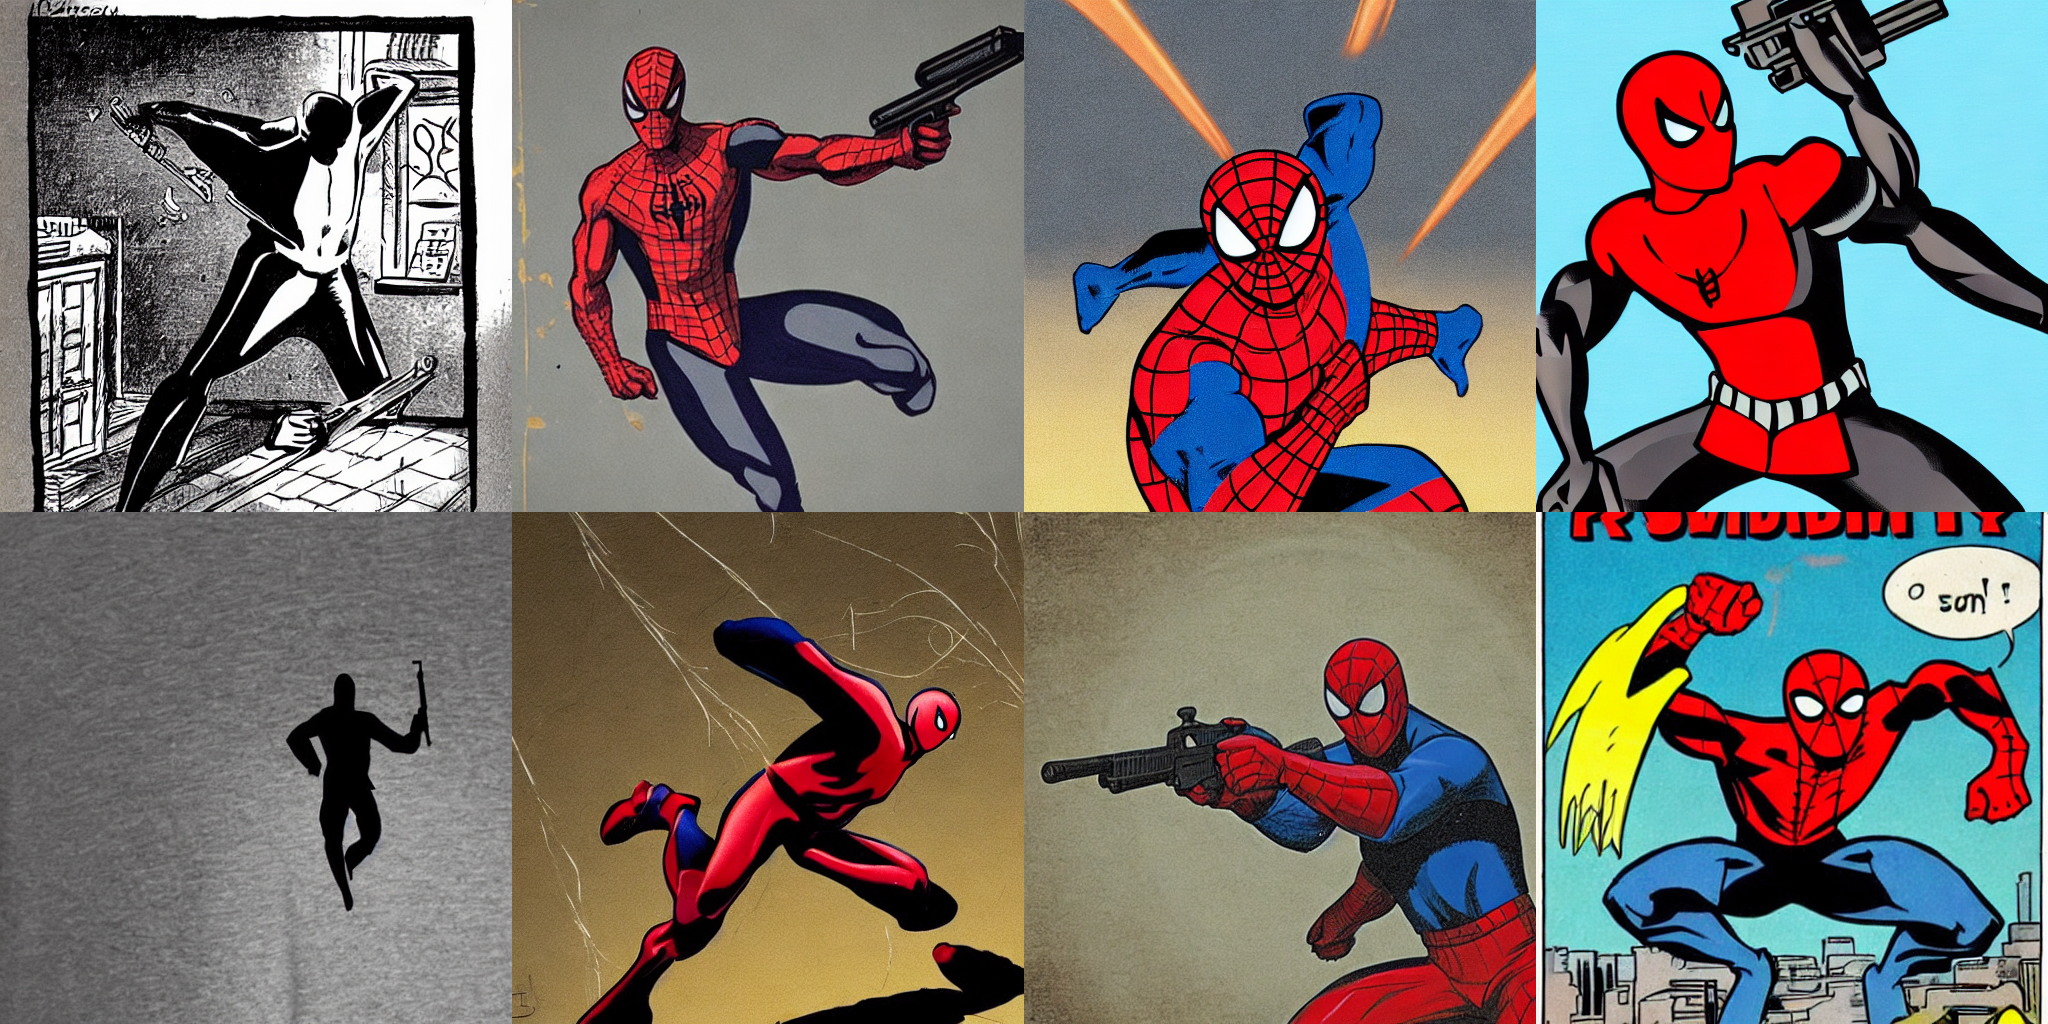

In [17]:
image_grid(imgs, 2, 4)
